In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import numpy as np
import glob
import matplotlib as mpl
import netCDF4 as nc
from shapely.geometry import Polygon, LineString, Point
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import os
import cartopy.feature as cfeature
import xarray as xr
import geopandas as gpd
import contextily as cx
import h5py

In [2]:
def calc_dist_to_ocean(this_lons, this_lats):
    i=2
    x = np.array([-118.7,-117.59,-116.48])-0.1+0.06*i
    y = np.array([34.1,33.4,32.7])-2/3*0.1+2/3*0.06*i
    xnew = np.linspace(x[0],x[2],100)
    ynew = np.interp(xnew, x, y)
    points = []
    for i_point in range(len(xnew)):
        points.append(Point(xnew[i_point],ynew[i_point]))

    lines = LineString(points)
    
    gs = gpd.GeoSeries(lines, crs='EPSG:4326').to_crs(epsg=3310)
    utm = gs.estimate_utm_crs()
    dists = []
    for i in range(len(this_lons)):
        this_gp = gpd.GeoSeries(Point(this_lons[i],this_lats[i]), crs="EPSG:4326")
        dists.append(gs.to_crs(utm).distance(this_gp.to_crs(utm))[0]/1e3)
    return dists

In [3]:
def define_reg_by_distance_to_ocean(gdf):
    for i in range(2,15):
        x = np.array([-118.7,-117.65+0.06])-0.1+0.06*i
        y = np.array([34.1,33.4])-2/3*0.1+2/3*0.06*i
        xnew = np.linspace(x[0],x[1],100)
        ynew = np.interp(xnew, x, y)

        for i_point in range(len(xnew)):
            indx = gdf['geometry'].contains(Point(xnew[i_point],ynew[i_point]))
            gdf.loc[indx,'dis'] = i
            gdf.loc[indx,'dis_km'] = dists[i]-dists[2]
            gdf.loc[indx,'dis_lon'] = np.mean(x)
    return gdf

In [4]:
datapath = '/Users/zhu/Dropbox/Code/Publications/ZEV-adoption-analysis-data/'
shapefile = gpd.read_file(r"/Users/zhu/Dropbox/Database/Hera/LA_Merge/LA_Merge.shp")

In [5]:

oceanshp = gpd.read_file(r'/Users/zhu/Dropbox/Database/Hera/ne_10m_ocean/ne_10m_ocean.shp')

In [6]:
arrays = {}

filenames = ['vocr_daily_wrf_chem_berk_vcp_noI_phot_soa_siloxane_ivoc_nald_t0_4km.mat']
vocr_combs = []
for filename in filenames:
    f = h5py.File(datapath + filename)
    for k, v in f.items():
        print(v)
        arrays[k] = np.array(v)
    this_vocr = arrays['vocr_comb']
    this_vocr = np.nansum(this_vocr[:,:,1:,:],axis=2)
    vocr_combs.append(this_vocr)
    xloncorn = arrays['xloncorn']
    xlatcorn = arrays['xlatcorn']
    lon = arrays['lon']
    lat = arrays['lat']

<HDF5 group "/#refs#" (56 members)>
<HDF5 dataset "fns": shape (1, 55), type "|O">
<HDF5 dataset "lat": shape (324, 264), type "<f8">
<HDF5 dataset "lon": shape (324, 264), type "<f8">
<HDF5 dataset "t_comb": shape (11, 324, 264, 31), type "<f8">
<HDF5 dataset "vocr_comb": shape (324, 264, 55, 31), type "<f8">
<HDF5 dataset "vocr_rate_comb": shape (324, 264, 55, 31), type "<f8">
<HDF5 dataset "xlatcorn": shape (324, 264, 4), type "<f8">
<HDF5 dataset "xloncorn": shape (324, 264, 4), type "<f8">


In [7]:
voc_names = ['co','ch4','eth','hc3','hc5','hc8','ete','olt','oli','dien','ace','ben','tol',
    'xyl','xyo','iso','api','lim','hcho','acd','ald','act','mek','ket','hket','macr','mvk',
    'uald','gly','mgly','dcb1','dcb2','dcb3','bald','phen','csl','epx','mct','moh','eoh','roh',
    'eteg','op1','op2','glyc','uhc','d4silx','d5silx','pcbtf','pdcbz','nald','oald','cuald','cald','eclp']
len(voc_names)

55

In [8]:
lon = lon.flatten()
lat = lat.flatten()
area_indx = np.zeros(np.size(lon))
cls_indxs = []
for i in range(len(lon)):
    point = Point(lon[i], lat[i])
    classdefs = shapefile.loc[:,'geometry'].contains(point)
    if classdefs.any():
        area_indx[i] = 1
        
    classdefs_index = [k for k, x in enumerate(classdefs) if x]
    if len(classdefs_index) == 1:
        cls_indxs.append(classdefs_index[0])
    else:
        cls_indxs.append(5)
cls_indxs = np.array(cls_indxs)

In [9]:
fns = ['co','ch4','eth','hc3','hc5','hc8','ete','olt','oli','dien','ace','ben','tol','xyl','xyo','iso','api','lim',
       'hcho','acd','ald','act','mek','ket','hket','macr','mvk','uald','gly','mgly','dcb1','dcb2','dcb3','bald',
       'phen','csl','epx','mct','moh','eoh','roh','eteg','op1','op2','glyc','uhc','d4silx','d5silx','pcbtf','pdcbz',
       'nald','oald','cuald','cald','eclp']
clon1 = xloncorn[:,:,0]
clon2 = xloncorn[:,:,1]
clon3 = xloncorn[:,:,2]
clon4 = xloncorn[:,:,3]

clat1 = xlatcorn[:,:,0]
clat2 = xlatcorn[:,:,1]
clat3 = xlatcorn[:,:,2]
clat4 = xlatcorn[:,:,3]

In [12]:
#save everyday
recap_days = list(range(1,32))

filenames = ['mda8o3_wrf_chem_berk_vcp_noI_phot_soa_siloxane_ivoc_nald_4km',
            'mda8o3_wrf_chem_berk_vcp_noI_phot_soa_siloxane_ivoc_nald_t5_4km',
            'mda8o3_wrf_chem_berk_vcp_noI_phot_soa_siloxane_ivoc_nald_t6_4km',
            'mda8o3_wrf_chem_berk_vcp_noI_phot_soa_siloxane_ivoc_nald_t9_4km',
            'mda8o3_wrf_chem_berk_vcp_noI_phot_soa_siloxane_ivoc_nald_t7_4km']
#datapath = '/Users/zhu/Dropbox/Database/Hera/surf_map_final/'
xlim =  [-118.6,-117.1]
ylim = [33.5,34.2] 

read_dist = True
gdfs = []
for filename in filenames:
    print(filename)
    this_df_wrf = pd.DataFrame()
    for this_day in recap_days:
        output_filename_thisday = datapath + '2021-08-{:02d}-'.format(this_day) + filename+'.nc'
        #print(output_filename_thisday)
        ds = xr.open_dataset(output_filename_thisday)
        #mda8_o3 = ds['pan']
        mda8_o3 = ds['__xarray_dataarray_variable__'].values
    

        df_wrf = pd.DataFrame(data={'lon':lon.flatten(), 'lat':lat.flatten(),'o3':mda8_o3.flatten(),'cls_indxs':cls_indxs.flatten(),
                               'clon1':clon1.flatten(), 'clon2':clon2.flatten(),'clon3':clon3.flatten(),'clon4':clon4.flatten(),
                               'clat1':clat1.flatten(), 'clat2':clat2.flatten(),'clat3':clat3.flatten(),'clat4':clat4.flatten()})
        indx = (df_wrf['lon'] >= xlim[0]) & (df_wrf['lon'] <= xlim[1]) & (df_wrf['lat'] >= ylim[0]) & (df_wrf['lat'] <= ylim[1])
        #indx =area_indx == 1
        df_wrf = df_wrf.loc[indx,:]
        df_wrf.loc[:,'day'] = this_day
        if read_dist:
            dists = calc_dist_to_ocean(df_wrf['lon'].values, df_wrf['lat'].values)
            read_dist = False
        df_wrf.loc[:,'dist'] = dists
        this_df_wrf = pd.concat([this_df_wrf, df_wrf])
    this_df_wrf = this_df_wrf.reset_index()   
    geometry_polygon = [Polygon([[this_df_wrf.loc[i,'clon1'], this_df_wrf.loc[i,'clat1']],
            [this_df_wrf.loc[i,'clon2'], this_df_wrf.loc[i,'clat2']],
            [this_df_wrf.loc[i,'clon3'], this_df_wrf.loc[i,'clat3']],
            [this_df_wrf.loc[i,'clon4'], this_df_wrf.loc[i,'clat4']]]) for i in this_df_wrf.index]
    gdf = gpd.GeoDataFrame(this_df_wrf, geometry=geometry_polygon)
    gdf.loc[:,'index'] = range(gdf.shape[0])
    #gdf = define_reg_by_distance_to_ocean(gdf)
    #gdf = gdf.groupby(['clon1','clon2','clon3','clon4','clat1','clat2','clat3','clat4']).agg('mean').reset_index()
    gdf = gdf.loc[land_indx,:].set_crs('epsg:4326',allow_override=True)
    gdfs.append(gdf)


mda8o3_wrf_chem_berk_vcp_noI_phot_soa_siloxane_ivoc_nald_4km
mda8o3_wrf_chem_berk_vcp_noI_phot_soa_siloxane_ivoc_nald_t5_4km
mda8o3_wrf_chem_berk_vcp_noI_phot_soa_siloxane_ivoc_nald_t6_4km
mda8o3_wrf_chem_berk_vcp_noI_phot_soa_siloxane_ivoc_nald_t9_4km
mda8o3_wrf_chem_berk_vcp_noI_phot_soa_siloxane_ivoc_nald_t7_4km


In [ ]:
#for i in range(len(gdfs)):
#    gdfs[i].loc[:,'dist'] = calc_dist_to_ocean(gdfs[i]['lon'].values, gdfs[i]['lat'].values)

In [11]:
mask_data = pd.DataFrame()
mask_data['coords'] = list(zip(gdf['lon'],gdf['lat']))
mask_data['coords'] = mask_data['coords'].apply(Point)

points = gpd.GeoDataFrame(mask_data, geometry='coords')
mask_data = gpd.tools.sjoin(points, oceanshp, predicate="within", how='left')
land_indx = np.isnan(mask_data['index_right'].values)


/var/folders/77/pb109gb144179sms3gzb4cfc0000gn/T/ipykernel_55988/843703717.py:6: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  mask_data = gpd.tools.sjoin(points, oceanshp, predicate="within", how='left')


In [15]:
#o3
recap_days = list(range(1,32))

filenames = ['mda8o3_wrf_chem_berk_vcp_noI_phot_soa_siloxane_ivoc_nald_4km',
            'mda8o3_wrf_chem_berk_vcp_noI_phot_soa_siloxane_ivoc_nald_t5_4km',
            'mda8o3_wrf_chem_berk_vcp_noI_phot_soa_siloxane_ivoc_nald_t6_4km',
            'mda8o3_wrf_chem_berk_vcp_noI_phot_soa_siloxane_ivoc_nald_t9_4km',
            'mda8o3_wrf_chem_berk_vcp_noI_phot_soa_siloxane_ivoc_nald_t7_4km']
#datapath = '/Users/zhu/Dropbox/Database/Hera/surf_map_final/'
xlim =  [-118.6,-117.1]
ylim = [33.5,34.2] 

mda8_o3_tots = []
for filename in filenames:
    print(filename)
    for this_day in recap_days:
        
        output_filename_thisday = datapath + '2021-08-{:02d}-'.format(this_day) + filename+'.nc'
        #print(output_filename_thisday)
        ds = xr.open_dataset(output_filename_thisday)
        #mda8_o3 = ds['pan']
        mda8_o3 = ds['__xarray_dataarray_variable__']
        #mda8_o3 = np.nanmean(mda8_o3, axis=0)
        if this_day == 1:
            mda8_o3_tot = mda8_o3
        else:
            mda8_o3_tot = mda8_o3_tot + mda8_o3
    mda8_o3_tot = mda8_o3_tot/len(recap_days)
    mda8_o3_tots.append(mda8_o3_tot)

gdfs = []
read_dist = True
for mda8_o3_tot in mda8_o3_tots:
    o3 = mda8_o3_tot.values
    df_wrf = pd.DataFrame(data={'lon':lon.flatten(), 'lat':lat.flatten(),'o3':o3.flatten(),'cls_indxs':cls_indxs.flatten(),
                           'clon1':clon1.flatten(), 'clon2':clon2.flatten(),'clon3':clon3.flatten(),'clon4':clon4.flatten(),
                           'clat1':clat1.flatten(), 'clat2':clat2.flatten(),'clat3':clat3.flatten(),'clat4':clat4.flatten()})
    indx = (df_wrf['lon'] >= xlim[0]) & (df_wrf['lon'] <= xlim[1]) & (df_wrf['lat'] >= ylim[0]) & (df_wrf['lat'] <= ylim[1])
    #indx =area_indx == 1
    df_wrf = df_wrf.loc[indx,:]
    if read_dist:
        dists = calc_dist_to_ocean(df_wrf['lon'].values, df_wrf['lat'].values)
        read_dist = False
    df_wrf.loc[:,'dist'] = dists
    geometry_polygon = [Polygon([[df_wrf.loc[i,'clon1'], df_wrf.loc[i,'clat1']],
            [df_wrf.loc[i,'clon2'], df_wrf.loc[i,'clat2']],
            [df_wrf.loc[i,'clon3'], df_wrf.loc[i,'clat3']],
            [df_wrf.loc[i,'clon4'], df_wrf.loc[i,'clat4']]]) for i in df_wrf.index]
    gdf = gpd.GeoDataFrame(df_wrf, geometry=geometry_polygon)
    gdf.loc[:,'index'] = range(gdf.shape[0])
    #gdf = define_reg_by_distance_to_ocean(gdf)
    #gdf = gdf.groupby(['clon1','clon2','clon3','clon4','clat1','clat2','clat3','clat4']).agg('mean').reset_index()
    gdf = gdf.loc[land_indx,:].set_crs('epsg:4326',allow_override=True)
    gdfs.append(gdf)


mda8o3_wrf_chem_berk_vcp_noI_phot_soa_siloxane_ivoc_nald_4km
mda8o3_wrf_chem_berk_vcp_noI_phot_soa_siloxane_ivoc_nald_t5_4km
mda8o3_wrf_chem_berk_vcp_noI_phot_soa_siloxane_ivoc_nald_t6_4km
mda8o3_wrf_chem_berk_vcp_noI_phot_soa_siloxane_ivoc_nald_t9_4km
mda8o3_wrf_chem_berk_vcp_noI_phot_soa_siloxane_ivoc_nald_t7_4km


In [14]:
mask_data = pd.DataFrame()
mask_data['coords'] = list(zip(gdf['lon'],gdf['lat']))
mask_data['coords'] = mask_data['coords'].apply(Point)

points = gpd.GeoDataFrame(mask_data, geometry='coords')
mask_data = gpd.tools.sjoin(points, oceanshp, predicate="within", how='left')
land_indx = np.isnan(mask_data['index_right'].values)


/var/folders/77/pb109gb144179sms3gzb4cfc0000gn/T/ipykernel_55988/843703717.py:6: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  mask_data = gpd.tools.sjoin(points, oceanshp, predicate="within", how='left')


(0.0, 90.0)

findfont: Font family ['Time New Roman'] not found. Falling back to DejaVu Sans.


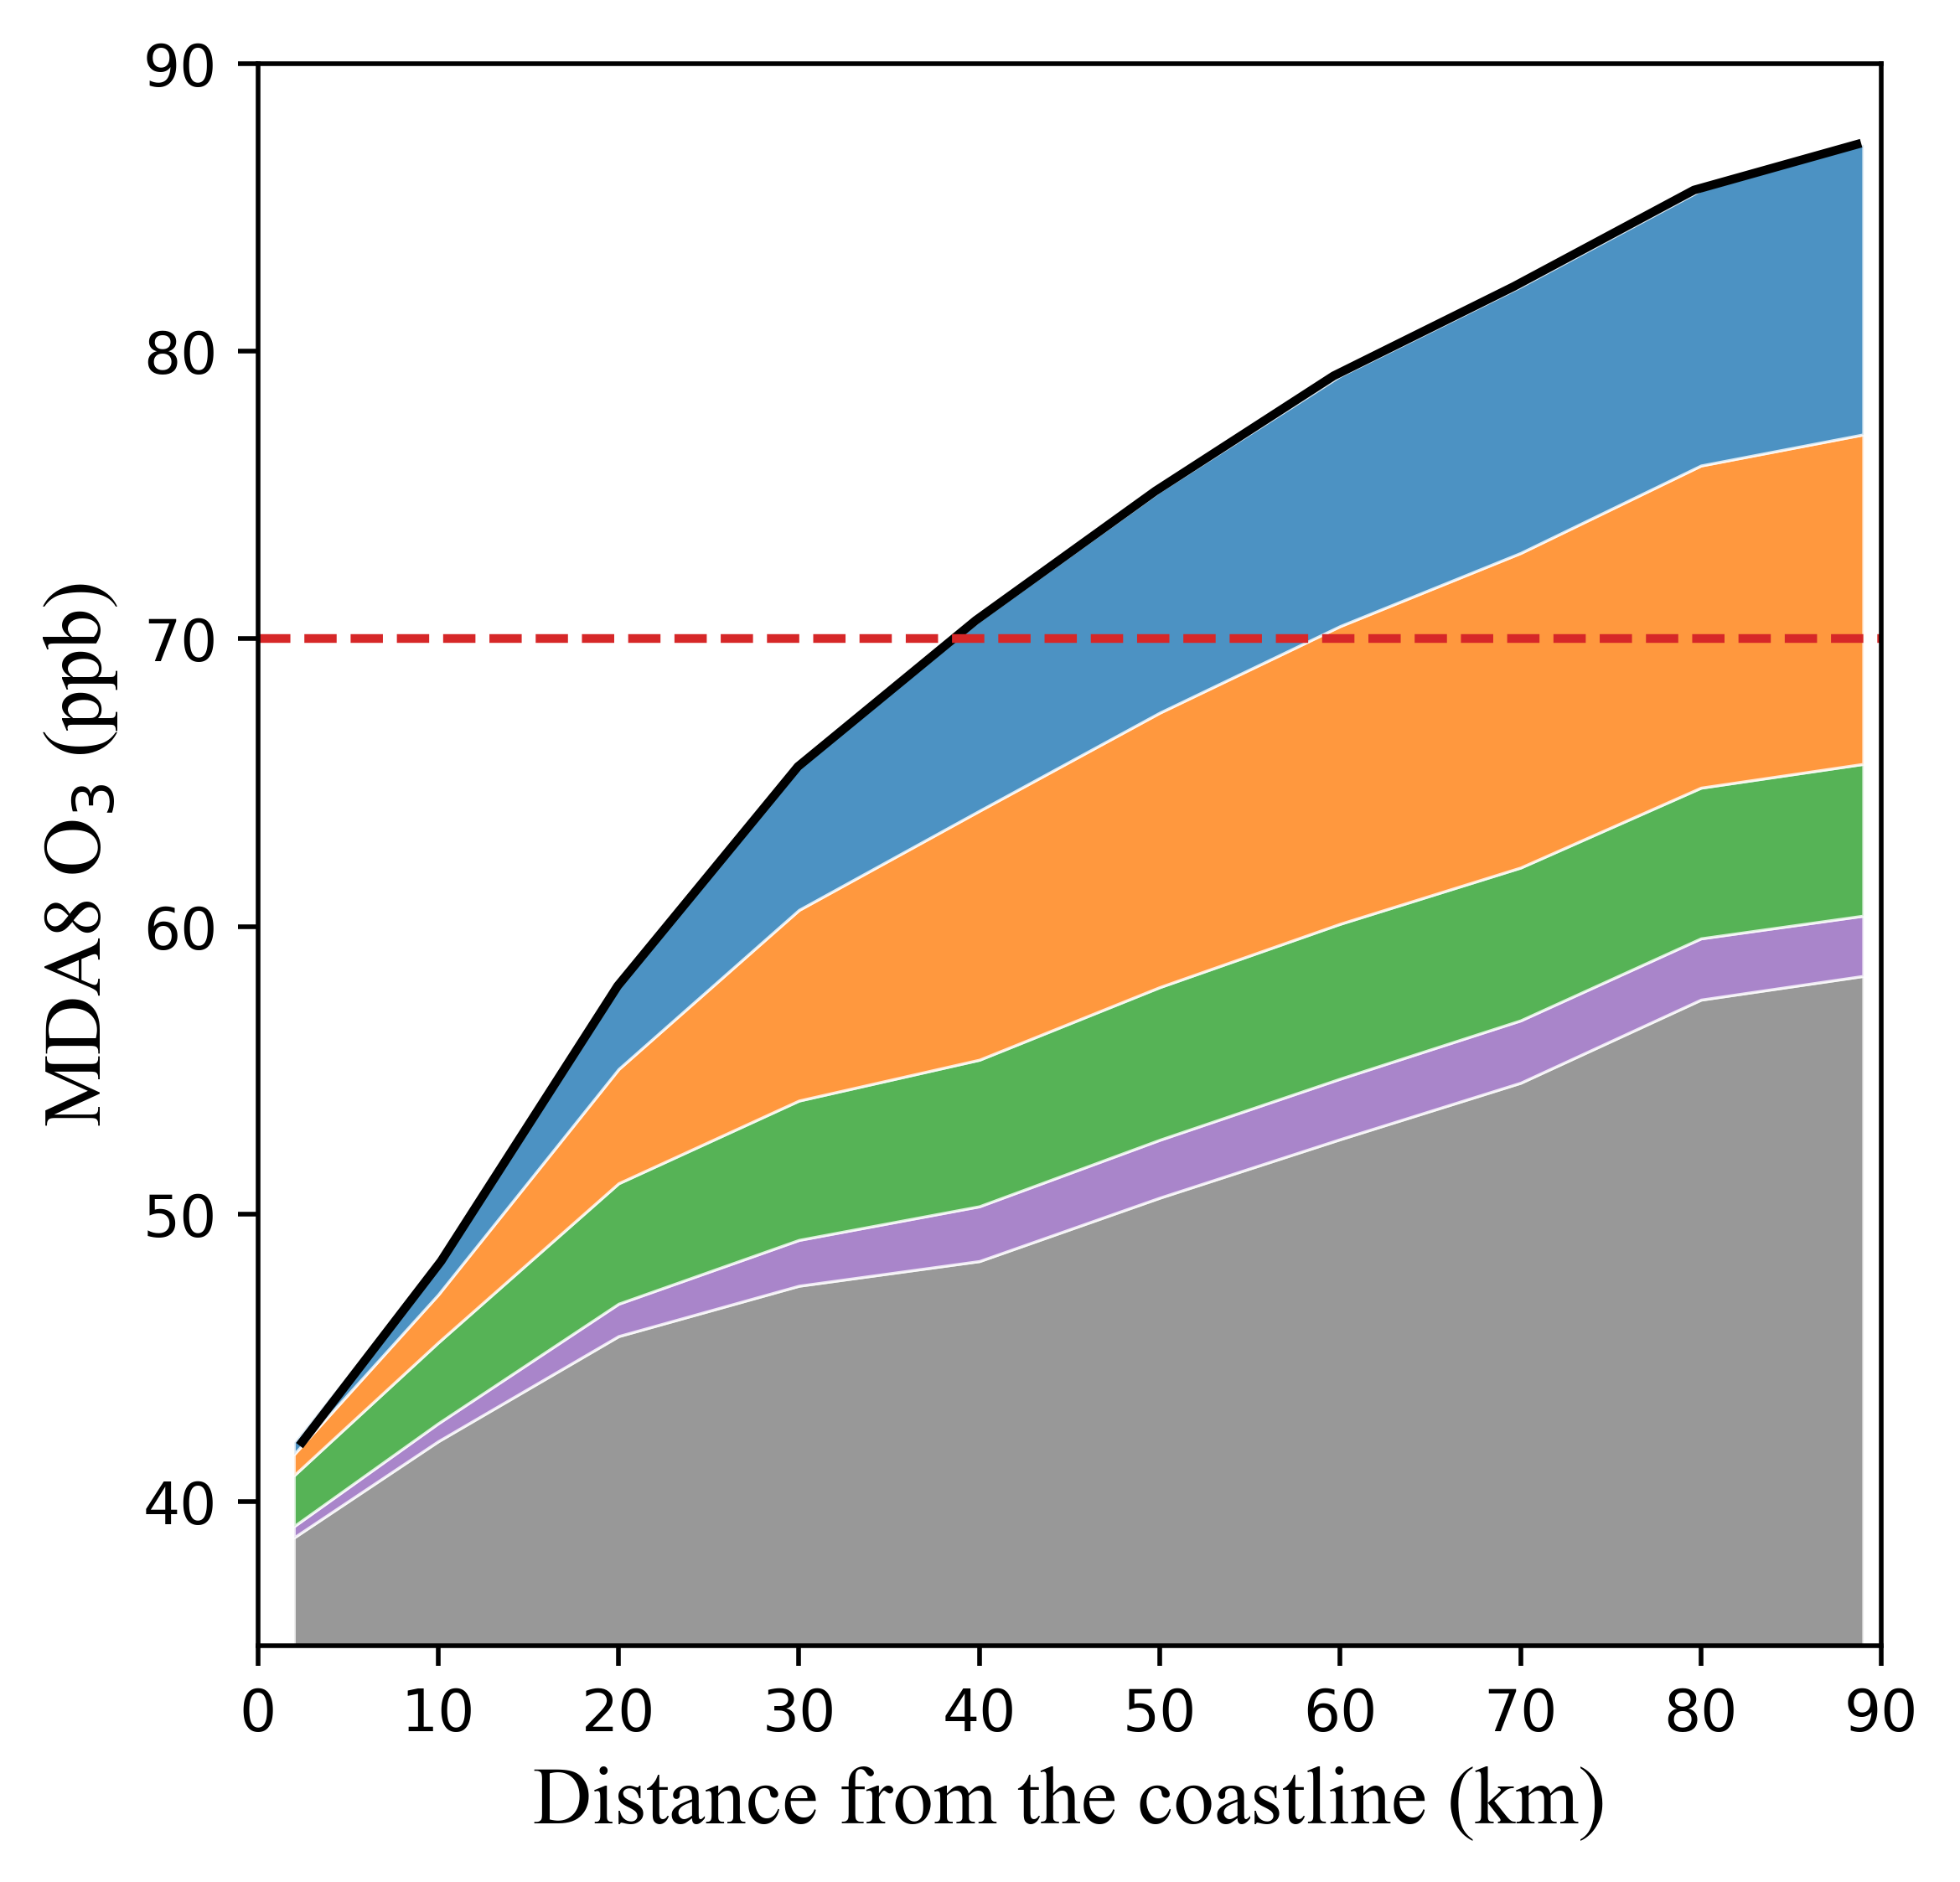

In [17]:
spc='o3'
o3_daily_nox = pd.DataFrame()
dis_lons = []
dis_kms = []
tot_fulls = []
this_dist_reg = gdfs[1]
for i in range(10):
    west_indx = (np.round(gdfs[1]['dist']/10)).astype(int)==i
    #dis_lons.append(gdfs[1].loc[west_indx,'dis_lon'].values[0])
    dis_kms.append(gdfs[1].loc[west_indx,'dist'].mean())
    
    o3_daily_nox.loc[i,'Onroad gasoline'] = gdfs[0].loc[west_indx,spc].mean() - gdfs[1].loc[west_indx,spc].mean()
    o3_daily_nox.loc[i,'Onroad diesel'] = gdfs[1].loc[west_indx,spc].mean() - gdfs[2].loc[west_indx,spc].mean()
    o3_daily_nox.loc[i,'Offroad gasoline'] = gdfs[2].loc[west_indx,spc].mean() - gdfs[3].loc[west_indx,spc] .mean()
    o3_daily_nox.loc[i,'Offroad diesel'] = gdfs[3].loc[west_indx,spc].mean() - gdfs[4].loc[west_indx,spc] .mean()
    o3_daily_nox.loc[i,'tot'] = gdfs[4].loc[west_indx,spc].mean()
    o3_daily_nox.loc[i,'tot_gasoline'] = gdfs[1].loc[west_indx,spc].mean()
    tot_fulls.append(gdfs[0].loc[west_indx,spc].mean())
    #o3_daily_nox.loc[i,'tot_full'] = gdfs[0].loc[west_indx,spc].mean()
    o3_daily_nox.loc[i,'location'] = 'West/Central LA'

label = 'MDA8 O$_3$'
fig, axs = plt.subplots(1,1,figsize=(5,5),dpi=500)
plt.rcParams["font.family"] = "Time New Roman"

#boxcolors = ['tab:gray','tab:orange','tab:purple','tab:red','tab:blue','tab:red']
this_data = o3_daily_nox.loc[:,['tot','Offroad diesel','Offroad gasoline','Onroad diesel','Onroad gasoline']].sort_index()
#this_data.loc[:,'dist'] = dis_kms

colors=np.flip(['tab:blue','tab:orange','tab:green','tab:purple','tab:gray'])
#sns.lineplot(x='dist',y='')
#colors=np.flip(['tab:purple','tab:green','tab:orange','tab:blue'])
axs.stackplot(np.round(dis_kms), np.transpose(this_data.values),alpha=0.8,lw=0.5, edgecolor='white', colors = colors)
#axs.legend(['Onroad gasoline','Onroad diesel','Offroad gasoline','Offroad diesel'],bbox_to_anchor=(1.6, 1.05))
axs.legend(['Offroad diesel','Offroad gasoline','Onroad diesel','Onroad gasoline','Tot'],loc=2)
axs.get_legend().remove()
sns.lineplot(x=dis_kms, y=tot_fulls,ax=axs,color='k',linestyle='-')
#sns.lineplot(x=[10,10],y=[0,1],ax=axs,color='k',linestyle='--')
#sns.lineplot(x=[15,15],y=[0,1],ax=axs,color='k',linestyle='--')
#sns.lineplot(x=[35,35],y=[0,1],ax=axs,color='k',linestyle='--')
#sns.lineplot(x=[60,60],y=[0,1],ax=axs,color='k',linestyle='--')
#sns.lineplot(x=[80,80],y=[0,1],ax=axs,color='k',linestyle='--')
sns.lineplot(x=[0,90],y=[70,70],ax=axs,color='tab:red',linestyle='--')

axs.set_xlabel('Distance from the coastline (km)',**{'fontname':"Times New Roman"},fontsize=14)
axs.set_ylabel('MDA8 O$_3$ (ppb)',**{'fontname':"Times New Roman"},fontsize=14)

axs.set_ylim([35,90])
axs.set_xlim([0,90])